In [1]:
import time
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

from qubovert.sim import anneal_qubo
from qubovert import boolean_var

import random
from dwave.cloud import Client

#eth email:
#TOKEN = 'DEV-0d65e0f7a19d10d5c0d2fd33c1c88ea7107669a1'
#gmail:
TOKEN = 'DEV-8106d9f8d3de6f69c939f8a459aa10c40eaa70c3'

from scipy import linalg
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso

from dwave.cloud import config

from dwave.system import DWaveSampler, EmbeddingComposite

import networkx as nx
from minorminer import find_embedding

import dimod
from tabu import TabuSampler

In [63]:
from dwave.cloud import config as dwave_config

In [2]:
def update_m(X,y,w,alpha):
    D = X.shape[1]

    m = {i: boolean_var('m(%d)' % i) for i in range(D)}

    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)

    model = 0
    for i in range(D):
        for j in range(D):
            model += m[i]*(A[i][j]+1e-9)*m[j]
        model += (b[i]+1e-9)*m[i]
        
    time_start = time.time()
    #res = anneal_qubo(model, num_anneals=10)
    res = anneal_qubo(model, num_anneals=1)
    model_solution = res.best.state
    
    m = np.array(list(model_solution.values()))
    return(m)


def update_m_dwave(X,y,w,alpha):
    TOKEN = 'DEV-0d65e0f7a19d10d5c0d2fd33c1c88ea7107669a1'
    client = Client.from_config(token=TOKEN)
    #print(client.get_solvers())
    solver = client.get_solver(name='hybrid_binary_quadratic_model_version2')
    
    D = X.shape[1]

    m = {i: boolean_var('m(%d)' % i) for i in range(D)}

    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)

    model = 0
    for i in range(D):
        for j in range(D):
            model += m[i]*(A[i][j]+1e-9)*m[j]
        model += (b[i]+1e-9)*m[i]
        
    time_start = time.time()
    #res = anneal_qubo(model, num_anneals=10)
    res = anneal_qubo(model, num_anneals=1)
    model_solution = res.best.state
    
    m = np.array(list(model_solution.values()))
    return(m)


def qubo_bsc(X,y,alpha,h_bar,hardware="classical"):
    #binary sparse coding
    #h_bar acts like planck's constant- determines strength of individual state

    D = X.shape[1]
    w = np.ones(D)*h_bar
    if hardware=="classical":
        m = update_m(X,y,w,alpha)
    elif hardware == "dwave":
        m = update_m_dwave(X,y,w,alpha)
    else:
        raise(Exception)

    return(m*w) 

In [3]:
#dataset = "diabetes"
dataset = "sparse_coding"

if dataset == "diabetes":
    #gamma=0.02
    gamma = 1.0
    X_all, y_all = datasets.load_diabetes(return_X_y=True)
    print(X_all.shape)

    X_train = X_all[:150]
    y_train = y_all[:150]

    X = X_all[:150]
    y = y_all[:150]
    
    X_val = X_all[150:]
    y_val = y_all[150:]

elif dataset == "sparse_coding":
    gamma = 1.0
    np.random.seed(43)

    N_train = 36
    N_val = 720
    N_test = 36
    N = N_train+N_val+N_test

    #D = 100
    #D = 64
    D = 32
    D_small = 10
    mu, sigma = 0, 1.0

    X_all = np.random.normal(mu, sigma, size=(N,D))
    X_small = np.random.normal(mu, sigma, size=(N,D_small))
    w_opt = np.abs(np.random.normal(mu,sigma,size=D_small))
    y_all = np.matmul(X_small,w_opt)

    X_all[:,:D_small] = X_small
    X_train = X_all[:N_train]
    X_val = X_all[N_train:N_train+N_val]
    X_test = X_all[N_train+N_val:]

    y_train = y_all[:N_train]
    y_val = y_all[N_train:N_train+N_val]
    y_test = y_all[N_train+N_val:]

    X = X_all[:N_train]
    y = y_all[:N_train]


N = X.shape[0]
D = X.shape[1]

X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)
y_mean = np.mean(y)
y_std = np.std(y)

X = (X-X_mean)/X_std
y = (y-y_mean)/y_std

########################################################################

In [64]:
#algorithm: dwave hybrid

h_bar = 0.2

n_alphas = 16
alphas = np.logspace(-1, 2, n_alphas)

D = X.shape[1]
Q = {}

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])
    alpha = alphas[i]
    
    #embed to Q dict
    #hybrid solver: max_variables=1M, max_biases=20M (i.e. connections between variables)
    
    w = np.ones(D)*h_bar
    
    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)
    
    #Q = {(0,0):1,(0,1):2,(0,2):3}

    for j in range(0,D):
        Q[(i*D+j,i*D+j)] = A[j][j]+b[j]+1e-9
        for k in range(j+1,D):
            Q[(i*D+j,i*D+k)] = 2*A[j][k]+1e-9 #*2 because A is symmetric
                
            
            
    
    

0
alpha= 0.100000
1
alpha= 0.158489
2
alpha= 0.251189
3
alpha= 0.398107
4
alpha= 0.630957
5
alpha= 1.000000
6
alpha= 1.584893
7
alpha= 2.511886
8
alpha= 3.981072
9
alpha= 6.309573
10
alpha= 10.000000
11
alpha= 15.848932
12
alpha= 25.118864
13
alpha= 39.810717
14
alpha= 63.095734
15
alpha= 100.000000


0.9289976004579882

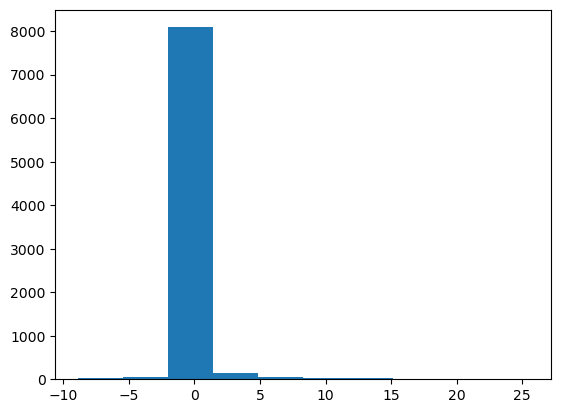

In [5]:
Q
Q_vals = np.array(list(Q.values()))
np.max(Q_vals)
plt.hist(Q_vals)
np.linspace(0,0.9,10)
np.quantile(np.abs(Q_vals),np.linspace(0,0.9,10))
len(Q)
np.quantile(np.abs(Q_vals),0.9)

In [65]:
sampler_advantage = DWaveSampler(solver={'topology__type':'pegasus'})
ec_advantage = EmbeddingComposite(sampler_advantage)

print(sampler_advantage.properties['chip_id'])
print(sampler_advantage.properties['num_qubits'])

G = nx.Graph()
G.add_edges_from(set(sampler_advantage.edgelist))
#print(G.edges)
print(len(G.edges))

#Q_pruned = {k:Q[k] for k in Q if np.abs(Q[k])>0.1*np.quantile(np.abs(Q_vals),0.9)}
#len(Q_pruned)

#G.adj

Advantage_system6.1
5760
40135


In [7]:
#emb = find_embedding(Q_pruned,G.edges,random_seed=10)
emb = find_embedding(Q,G.edges,random_seed=10)

In [8]:
emb

{0: [4826, 2410, 4827, 2408, 2409],
 1: [2169, 2125, 2589, 2590, 2575, 4871, 4872, 2170, 4873],
 2: [2153, 2574, 4558, 4557, 2079, 2078, 4556],
 3: [2424, 4676, 4678, 4677],
 4: [4438, 4617, 2500, 4618, 2498, 4633, 2499],
 5: [4721, 4723, 2274, 4722],
 6: [4527, 4528, 2545, 2544, 2543],
 7: [4737, 2290, 2288, 2289],
 8: [4948, 4947, 2260, 2258, 2259],
 9: [2514, 4753, 4751, 4752],
 10: [5007, 4481, 4482, 4588, 2440, 2439, 2438],
 11: [4511, 4512, 2604, 2603, 4754, 4513],
 12: [4798, 2230, 2228, 4797, 2229],
 13: [4660, 4661, 4663, 4662],
 14: [2109, 2110, 4886, 2559, 2515, 4828, 4888, 4887, 2560],
 15: [4437, 2363, 2366, 2364, 2365],
 16: [2335, 2333, 2334],
 17: [4933, 4932, 2216, 2213, 2546, 2215, 4587, 2214],
 18: [4573, 4574, 2198, 2200, 4572, 2199],
 19: [2485, 4813, 2244, 4810, 4812, 4811],
 20: [2318, 2319, 4842, 2320],
 21: [2393, 4632, 4631, 2395, 2394],
 22: [4918, 4917, 2348, 2349, 2351, 2350],
 23: [4498, 2455, 2454, 4496, 4497, 2453],
 24: [2530, 4738, 4783, 2094, 4782, 47

In [66]:
sampleset = ec_advantage.sample_qubo(Q,num_reads=100)

In [79]:
sampleset

SampleSet(rec.array([([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,

In [77]:
len(sampleset)

100

In [78]:
sampleset.info

{'timing': {'qpu_sampling_time': 21022.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 169.68,
  'qpu_access_time': 36948.37,
  'qpu_access_overhead_time': 1218.63,
  'qpu_programming_time': 15926.37,
  'qpu_delay_time_per_sample': 20.54,
  'post_processing_overhead_time': 2622.0,
  'total_post_processing_time': 2622.0},
 'problem_id': '5ba38c5e-bbde-421b-be8e-e8f1560efa2a'}

In [87]:
len(sampleset.record)

100

In [91]:
sampleset.record[0][2]

1

In [7]:
Q_tmp = np.random.randint(2,size=len(alphas)*D,dtype=np.int8)

In [8]:
Q_tmp

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,

In [9]:
init_state_dict = {i:Q_tmp[i] for i in range(len(alphas)*D)}
init_state = dimod.SampleSet.from_samples(dimod.as_samples(init_state_dict), 'BINARY', 0)

In [58]:
Q

{(0, 0): -7.974277387909542,
 (0, 1): 0.08315969291107264,
 (0, 2): 0.14718147133412285,
 (0, 3): -0.20575082261643965,
 (0, 4): 0.8692077034446919,
 (0, 5): -0.17282576940435376,
 (0, 6): -0.01436248317263681,
 (0, 7): 0.3028729563743214,
 (0, 8): -0.2672489081113061,
 (0, 9): -0.18435677429321817,
 (0, 10): 0.7113362256108273,
 (0, 11): -0.053344725852513826,
 (0, 12): -0.7117069555433087,
 (0, 13): 0.6854492187373136,
 (0, 14): 0.012864598096125324,
 (0, 15): 0.8702268815799834,
 (0, 16): 0.6063216243634416,
 (0, 17): -0.22558607352531493,
 (0, 18): -0.18945104361543472,
 (0, 19): 0.27229107274535724,
 (0, 20): -0.9456441308904594,
 (0, 21): 0.06696386675385761,
 (0, 22): 0.27242027932167323,
 (0, 23): 0.35037940601688516,
 (0, 24): 0.2157415961054618,
 (0, 25): -0.014462558440918805,
 (0, 26): 0.6349710575472804,
 (0, 27): 0.4681729456919141,
 (0, 28): 0.4143935888142777,
 (0, 29): 0.40940977648899385,
 (0, 30): -0.27442034934010784,
 (0, 31): -1.1524085310386611,
 (1, 1): -3.27340

In [10]:
#response = TabuSampler().sample_ising({'a': -0.5, 'b': 1.0}, {('a', 'b'): -1})
response = TabuSampler().sample_qubo(Q,init_states=init_state,seed=42)
V_best = response.record[0][1]
Q_best = response.record[0][0]


In [80]:
Q_best

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [11]:
V_best

-277.52129458738335

In [12]:
response

SampleSet(rec.array([([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,

In [13]:
#response.record[0]
response.record[0][1]

-277.52129458738335

In [14]:
response

SampleSet(rec.array([([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,

In [ ]:
                computation = solver.sample_qubo(Q_dicts[i],time_limit=3.5)
                logging.info(str(computation.id))
                logging.info(str(computation.variables))
                logging.info(str(computation.result))
                logging.info(str(computation.energies))
                logging.info(str(computation.samples))
                #print(computation.sampleset.to_pandas_dataframe())
                logging.info(str(computation.sampleset.variables))
                logging.info(str(computation.sampleset.info))
                total_qpu_access_time += computation.sampleset.info['qpu_access_time']

In [20]:
a = np.arange(0,10)[::-1]

In [21]:
a

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [22]:
a[[5,4,1,6]]

array([4, 5, 8, 3])

In [31]:
from hybrid.decomposers import EnergyImpactDecomposer
import dimod
from hybrid.utils import min_sample
from hybrid.core import State

In [40]:
import hybrid

In [41]:
hybrid

<module 'hybrid' from '/scratch_net/kringel/hchoong/conda_envs/quantum_cv3/lib/python3.8/site-packages/hybrid/__init__.py'>

In [28]:
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

In [24]:
decomposer = EnergyImpactDecomposer(size=32, rolling=True, rolling_history=1.0)

In [59]:
#state0 = State.from_sample(min_sample(bqm), bqm)
state0 = State.from_sample(Q_best, bqm)
 

In [62]:
State.from_sample()

TypeError: from_sample() missing 2 required positional arguments: 'sample' and 'bqm'

In [60]:
state0

{'problem': BinaryQuadraticModel({0: -7.974277387909542, 1: -3.273404421877064, 2: 0.7703587943846443, 3: 1.324578689420898, 4: -8.766037715475637, 5: -2.6336805469007096, 6: -6.055157149664412, 7: -1.922774595728452, 8: 4.747300867225112, 9: 0.8273633059026241, 10: -1.609862209507377, 11: 4.07897550386791, 12: 3.9568806664155467, 13: -0.18471497667412792, 14: 0.6289534907720429, 15: -0.8995343225666569, 16: 1.9895708901654179, 17: 1.3452387168319946, 18: 0.062247190032406335, 19: -0.10701618100669039, 20: 5.967471049561583, 21: 2.3231092411721743, 22: 0.9474438540281123, 23: 0.03364919743078723, 24: -1.2363393102406761, 25: 2.461895475291368, 26: 1.8297947976699338, 27: -0.3546918404849256, 28: 2.251465561123422, 29: -1.624998703886977, 30: 0.3604553127384315, 31: 7.074778525202742, 32: -7.9625795240603185, 33: -3.261706558027841, 34: 0.7820566582338665, 35: 1.3362765532701202, 36: -8.754339851626414, 37: -2.6219826830514865, 38: -6.043459285815189, 39: -1.9110767318792299, 40: 4.7589

In [34]:
min_sample(bqm)

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

In [35]:
state1 = decomposer.run(state0).result()

In [42]:
state1.subproblem.variables

Variables([456, 468, 479, 481, 482, 483, 485, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511])

In [37]:
list(state1.subproblem.variables)

[456,
 468,
 479,
 481,
 482,
 483,
 485,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511]

In [38]:
state2 = decomposer.run(state1).result()

In [39]:
list(state2.subproblem.variables)

[415,
 424,
 427,
 428,
 436,
 447,
 450,
 451,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 480,
 484,
 486]

In [84]:
b = np.random.random((3,5))

In [85]:
b

array([[0.04776388, 0.29784712, 0.01368902, 0.32819499, 0.97914015],
       [0.72695368, 0.49250246, 0.83828091, 0.7069907 , 0.3454593 ],
       [0.03282962, 0.70616757, 0.4984255 , 0.93792096, 0.24523912]])

In [86]:
np.dot(b,np.array([1,2,3,4,5]))

array([6.89300593, 8.78206065, 7.91832071])

In [57]:
b[[1,3]][:,[1,3]]

array([[0.76017893, 0.9056384 ],
       [0.76595419, 0.92661544]])

0
alpha= 0.100000
m*w= [0.2 0.2 0.  0.2 0.  0.2 0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.2 0.  0.2 0.2 0.
 0.2 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.  0.2 0.  0.2
 0.2 0.2 0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.2 0.2 0.  0.  0.
 0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0. ]
[ 1.11028487  2.63483427 -6.52929536  2.97908567  2.33947306 -0.96654426
 -6.57199715  7.24065531  0.99465158  0.01376616  1.34062792  4.14771692
 -1.57235411  4.78307849 -0.86880113 -1.96105385  0.23472488 -1.36923923
  0.56604269  3.52672401 -2.31458086  0.29589058 -1.70312347 -2.21084373
 -0.03828379  4.0982483   3.79028596 -3.52204841 -1.53302518 -2.42115466
  5.10570958  2.78731269  2.95611091 -0.1617112   6.48341686  3.93418259]
r2_train= 0.946816
r2_val= -0.157282
sqloss_val= 12620.182025
one_norm= 6.000000
zero_norm= 30.000000


1
alpha= 0.143845
m*w= [0.2 0.2

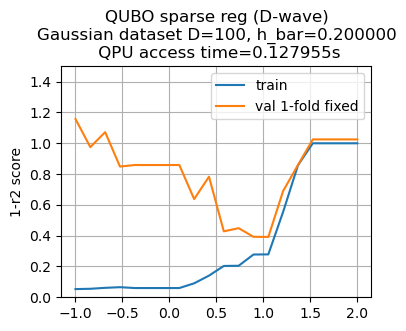

In [135]:


scores_train = []
scores_val = []
plot_y = np.zeros(n_alphas)

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])

    #mw = custom_algo(X,y,alphas[i],gamma)
    #mw = qubo_bsc(X=X,y=y,alpha=alphas[i],h_bar=h_bar)
    
    D = X.shape[1]
    w = np.ones(D)*h_bar
    m = computation.samples[0][i*D:(i+1)*D]
    mw = m*w
    
    #lasso = Lasso(alpha=alphas[i],fit_intercept=False,random_state=0, max_iter=10000)
    #lasso.fit(X, y)
    #mw = lasso.coef_
    
    y_train_pred = np.matmul(X,mw)*y_std+y_mean
    y_val_pred = np.matmul((X_val-X_mean)/X_std,mw)*y_std+y_mean
    SSres_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    SSres_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    SStot_train = np.dot(y_mean-y_train,y_mean-y_train)
    SStot_val = np.dot(np.mean(y_val)-y_val,np.mean(y_val)-y_val)

    r2_train = 1-SSres_train/SStot_train
    r2_val = 1-SSres_val/SStot_val
    
    one_norm = np.matmul(np.abs(mw),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(mw)>0,1,0),np.ones(D))
    #print(zero_norm)
    
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #plot_y.append(zero_norm)
    plot_y[i] = zero_norm
    #print(plot_y)
    
    print("m*w= %s"%(str(mw)))
    print(y_train_pred)
    print("r2_train= %f"%r2_train)
    print("r2_val= %f"%r2_val)
    print("sqloss_val= %f"%SSres_val)
    print("one_norm= %f"%one_norm)
    print("zero_norm= %f"%zero_norm)
    print("\n")

fig2 = plt.figure(figsize=(4,3))
ax2 = fig2.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax2.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax2.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
#ax2.plot(np.log10(alphas),plot_y)
title_text = "QUBO sparse reg (D-wave)\nGaussian dataset D=100, h_bar=%f"%h_bar
title_text += "\n QPU access time=%fs"%(computation.sampleset.info["qpu_access_time"]/1e6)
ax2.set_title(title_text)
#ax2.set_xlabel("log10(alpha)")
ax2.set_ylabel("1-r2 score")
#ax2.set_ylabel("|w|_0 zero norm")
ax2.set_ylim(0.0,1.5)
ax2.grid()
ax2.legend()
fig2.savefig('lasso_f2.png')

In [12]:
#import matplotlib.image as mpimg
from skimage.io import imread,imsave


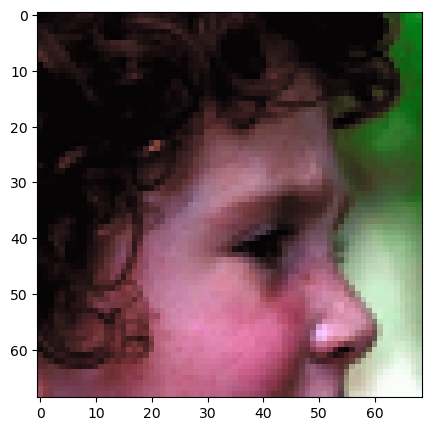

In [13]:
img_path = '/scratch_net/kringel/hchoong/github/quantum-cv/ScSR/data/val_lr/000005.png'

img_lr = imread(img_path)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

imgplot = ax1.imshow(img_lr)

plt.show()

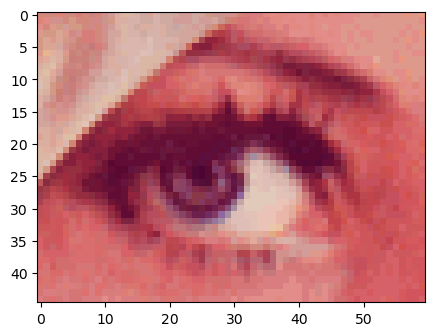

In [59]:
img_path = '/scratch_net/kringel/hchoong/github/quantum-cv/ScSR/data/val_hr/000008.png'
#img_path = '/scratch_net/kringel/hchoong/github/quantum-cv/data/Set5/HR/000000.png'

img_hr = imread(img_path)
img_hr = img_hr[240:285,240:300,:]
#img_hr = img_hr[240:290,300:360,:]
#img_hr = img_hr[160:240,295:395,:]

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

imgplot = ax1.imshow(img_hr)

plt.show()

In [60]:
imsave('/scratch_net/kringel/hchoong/github/quantum-cv/ScSR/data/val_single_small2_hr/000008.png',img_hr)